# Latex export of plots
This notebook was used for creating **Figures 5** and **6** in the paper. If you run this notebook in the supplied docker container, do not run the cell `[2]` and all cells calling the `display_tikz` function. This code shows the final figures which requires $\LaTeX$ and [tikzmagic](https://github.com/xblahoud/tikzmagic) installed in the system. We did not supply them to keep the size of the docker container reasonably small.

In [1]:
from ltlcross_wrapper import ResAnalyzer, gather_cumulative, gather_mins

In [2]:
import tikzmagic

def display_tikz(tikzcode, scale=1):
    preamble = r"""\usepackage{pgfplots}
\usepackage{xcolor}
"""
    return tikzmagic.tikzmagic.tikz(f"-s={scale} -b=0 -x='{preamble}'", tikzcode)

In [3]:
tool_set = ["yes.roll","yes.goal#fri","yes.goal#pit","yes.spot","yes.seminator#best"]
b = ResAnalyzer(f"data/random_nd.csv", cols=["states","time","acc","transitions"], tool_set=tool_set)
names = {
    "yes.seminator#best" : "Seminator 2",
    "yes.goal#pit" : "GOAL+Spot",
    "yes.goal#fri" : "Fribourg+Spot",
    "yes.roll" : "Roll+Spot",
    "yes.spot" : "Spot",
}

In [4]:
b.values.rename(columns=names, level=1, inplace=True)
b.tools = [names.get(t,t) for t in b.tools]
b.tool_set = [names.get(t,t) for t in b.tool_set]
b.exit_status.rename(columns=names, level=0, inplace=True)
args = {
    "width" : "5.5cm",
    "height" : "4.6cm",
    "log" : "both",
    "xlabel shift" : "-.1cm"
}

In [5]:
t1, t2 = "Spot","Seminator 2"
above = len(b.smaller_than(t1, t2))
below = len(b.smaller_than(t2, t1))
nodes = f"""%
\\draw[gray] (0,0) -- 
  node[above, sloped, magenta, pos=.5, font=\\tiny, align=center, inner sep=25pt] {{{t1}\\\\better in\\\\{above} cases}}
  node[below, sloped, magenta, pos=.5, font=\\tiny, align=center, inner sep=25pt] {{{t2}\\\\better in\\\\{below} cases}}
(130,130);
"""
labels = {
    "xlabel" : f"{{{t1} [\\#states]}}",
    "ylabel" : f"{{{t2} [\\#states]}}"
}
tikzcode = b.pgfplots_scatter_plot(t1,t2, include_equal=True, marks_dict={"fill" : "cyan", "fill opacity" : .3}, **labels, tikz_hook=nodes, diagonal=True, **args)
!mkdir -p ../fig
print(tikzcode, file=open("../fig/spot_sem_nd.tikz", "w"))

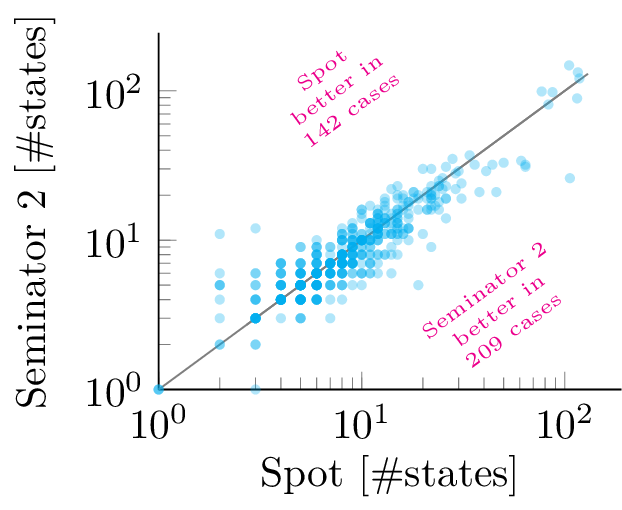

In [6]:
display_tikz(tikzcode)

In [7]:
t1, t2 = "Fribourg+Spot","Seminator 2"
above = len(b.smaller_than(t1, t2))
below = len(b.smaller_than(t2, t1))
nodes = f"""%
\\draw[gray] (0,0) -- 
  node[above, sloped, magenta, pos=.35, font=\\tiny, align=center, inner sep=25pt] {{{t1}\\\\better in\\\\{above} cases}}
  node[below, sloped, magenta, pos=.5, font=\\tiny, align=center, inner sep=25pt] {{{t2}\\\\better in\\\\{below} cases}}
(130,130);
"""
labels = {
    "xlabel" : f"{{{t1} [\\#states]}}",
    "ylabel" : f"{{{t2} [\\#states]}}"
}
tikzcode = b.pgfplots_scatter_plot(t1,t2, include_equal=True, marks_dict={"fill" : "cyan", "fill opacity" : .3}, **labels, tikz_hook=nodes, diagonal=True, **args)
!mkdir -p ../fig
print(tikzcode, file=open("../fig/frib_sem_nd.tikz", "w"))

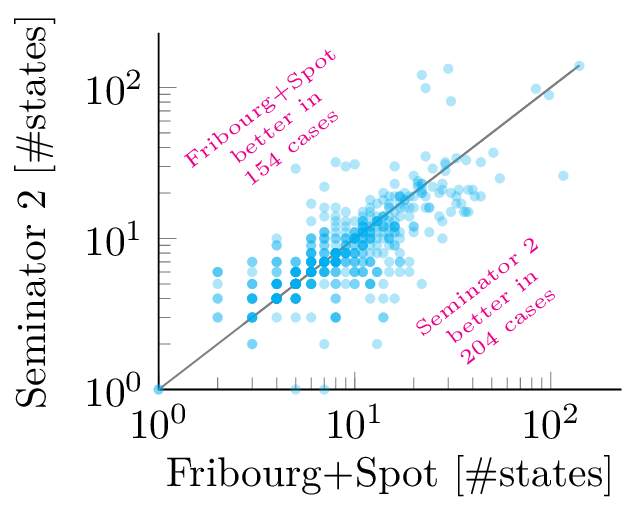

In [8]:
display_tikz(tikzcode)

## Cactus plot
This corresponds to **Figure 6** in the paper.

In [9]:
import pandas2pgfplots

In [10]:
tresh = 10
time = b.values.time.loc[:,b.tool_set]
data = time[(time["Fribourg+Spot"]>tresh) | (time["GOAL+Spot"]>tresh) | (time["Roll+Spot"]>tresh) | (time["Seminator 2"]>tresh) | (time["Spot"]>tresh)]

args = {
    "width" : "10cm",
    "height" : "4.6cm",
    "ylabel" : "{running time [sec.]}",
    "xlabel" : f"$n$-th fastest of the {len(data)} hard inputs",
    "xlabel shift" : "-.1cm",    
}
tikzcode = pandas2pgfplots.pandas2pgfplots.cactus(df=data, exclude_treshold=120,**args)
print(tikzcode, file=open("../fig/time_cactus.tikz", "w"))

In [11]:
len(data)

83

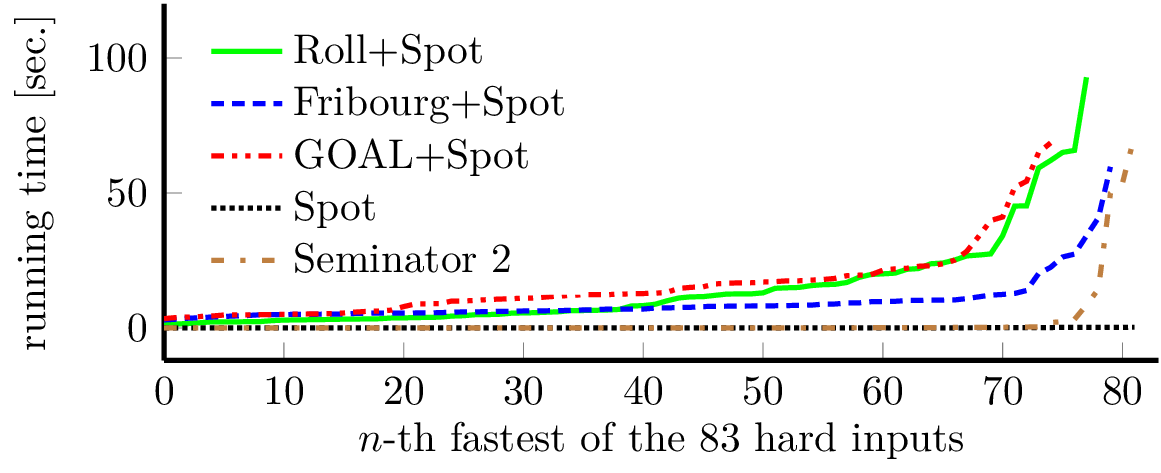

In [12]:
display_tikz(tikzcode)

## Table 3

In [13]:
import pandas as pd
pd.set_option("precision",0)

from tools import benchmark_names as names

In [14]:
benchmarks = {}
for name in names:
    b = ResAnalyzer(f"data/{name}.csv", tool_set=tool_set, cols=["states","time","acc","transitions","edges"])
    b.name = name
    b.orig_count = len(b.values)
    b.clean_count = len(b.values.dropna())
    benchmarks[name] = b

In [15]:
cum = gather_cumulative(benchmarks, highlight=False)
mins = gather_mins(benchmarks, highlight=False, unique_only=False)
mins.columns=mins.columns.droplevel(1)
df = pd.DataFrame()

for c in cum.columns:
    df[c] = cum[c].astype(int).astype(str)
    df[c] = df[c].str.cat(mins[c].astype(int).astype(str), sep=" (", join="left") + ")"
    
# Add formula counts
counts = {name: f"{b.clean_count}+{b.orig_count - b.clean_count}" for name, b in benchmarks.items()}
counts = pd.Series(counts, name="\# of formulas")
df = pd.DataFrame(counts).transpose().append(df.loc[tool_set])

df.columns = pd.MultiIndex.from_tuples([c.split("_") for c in df.columns]).swaplevel()
df = df.sort_index(axis=1)
df = df[["det","sd","nd"]]
df

det                     sd                     nd  \
                   literature      random literature      random literature   
\# of formulas          147+5       500+0       47+2       499+1       15+5   
yes.roll             1388 (0)    3687 (0)    833 (0)    5681 (4)    272 (0)   
yes.goal#fri        627 (137)  2530 (464)   290 (26)  3294 (258)   142 (14)   
yes.goal#pit        617 (143)  2490 (477)   277 (28)  3676 (125)    206 (5)   
yes.spot            611 (150)  2477 (489)   190 (40)  2829 (354)    181 (9)   
yes.seminator#best  622 (142)  2511 (465)   210 (37)  2781 (420)    169 (8)   

                                
                        random  
\# of formulas          486+14  
yes.roll             6225 (58)  
yes.goal#fri        5278 (238)  
yes.goal#pit         7713 (96)  
yes.spot            5310 (202)  
yes.seminator#best  4919 (277)

In [16]:
names_for_latex={
    "yes.spot" : "Spot",
    "yes.roll" : "ROLL+Spot",
    "yes.goal#fri": "Fribourg+Spot",
    "yes.goal#pit": "GOAL+Spot",
    "yes.seminator#best": "Seminator 2"
}
multicol = {
    "literature" : "\\multicolumn{1}{c}{literature}",
    "random" : "\\multicolumn{1}{c}{random}",
    "det" : "deterministic",
    "sd" :  "semi-detereministic",
    "nd" : "non-semi-deterministic",
}
df_latex = df.rename(index=names_for_latex, columns=multicol)

In [17]:
df_latex

deterministic                             \
               \multicolumn{1}{c}{literature} \multicolumn{1}{c}{random}   
\# of formulas                          147+5                      500+0   
ROLL+Spot                            1388 (0)                   3687 (0)   
Fribourg+Spot                       627 (137)                 2530 (464)   
GOAL+Spot                           617 (143)                 2490 (477)   
Spot                                611 (150)                 2477 (489)   
Seminator 2                         622 (142)                 2511 (465)   

                          semi-detereministic                             \
               \multicolumn{1}{c}{literature} \multicolumn{1}{c}{random}   
\# of formulas                           47+2                      499+1   
ROLL+Spot                             833 (0)                   5681 (4)   
Fribourg+Spot                        290 (26)                 3294 (258)   
GOAL+Spot                            277 (28)                 3676 (125)   
Spot                                 190 (40)                 2829 (354)   
Seminator 2                          210 (37)                 2781 (420)   

                       non-semi-deterministic                             
               \multicolumn{1}{c}{literature} \multicolumn{1}{c}{random}  
\# of formulas                           15+5                     486+14  
ROLL+Spot                             272 (0)                  6225 (58)  
Fribourg+Spot                        142 (14)                 5278 (238)  
GOAL+Spot                             206 (5)                  7713 (96)  
Spot                                  181 (9)                 5310 (202)  
Seminator 2                           169 (8)                 4919 (277)

In [18]:
latex = df_latex.to_latex(multicolumn_format="c", column_format="lcccccc", escape=False)
print(latex, file=open("../fig/tab.complement.tex","w"))

In [19]:
def display_table(latex):
    preamble = r"""\usepackage{booktabs}
    \usepackage[clock]{ifsym}
"""
    return tikzmagic.tikzmagic.tikz(f" --engine='pdflatex' -x='{preamble}' --no-wrap", latex)

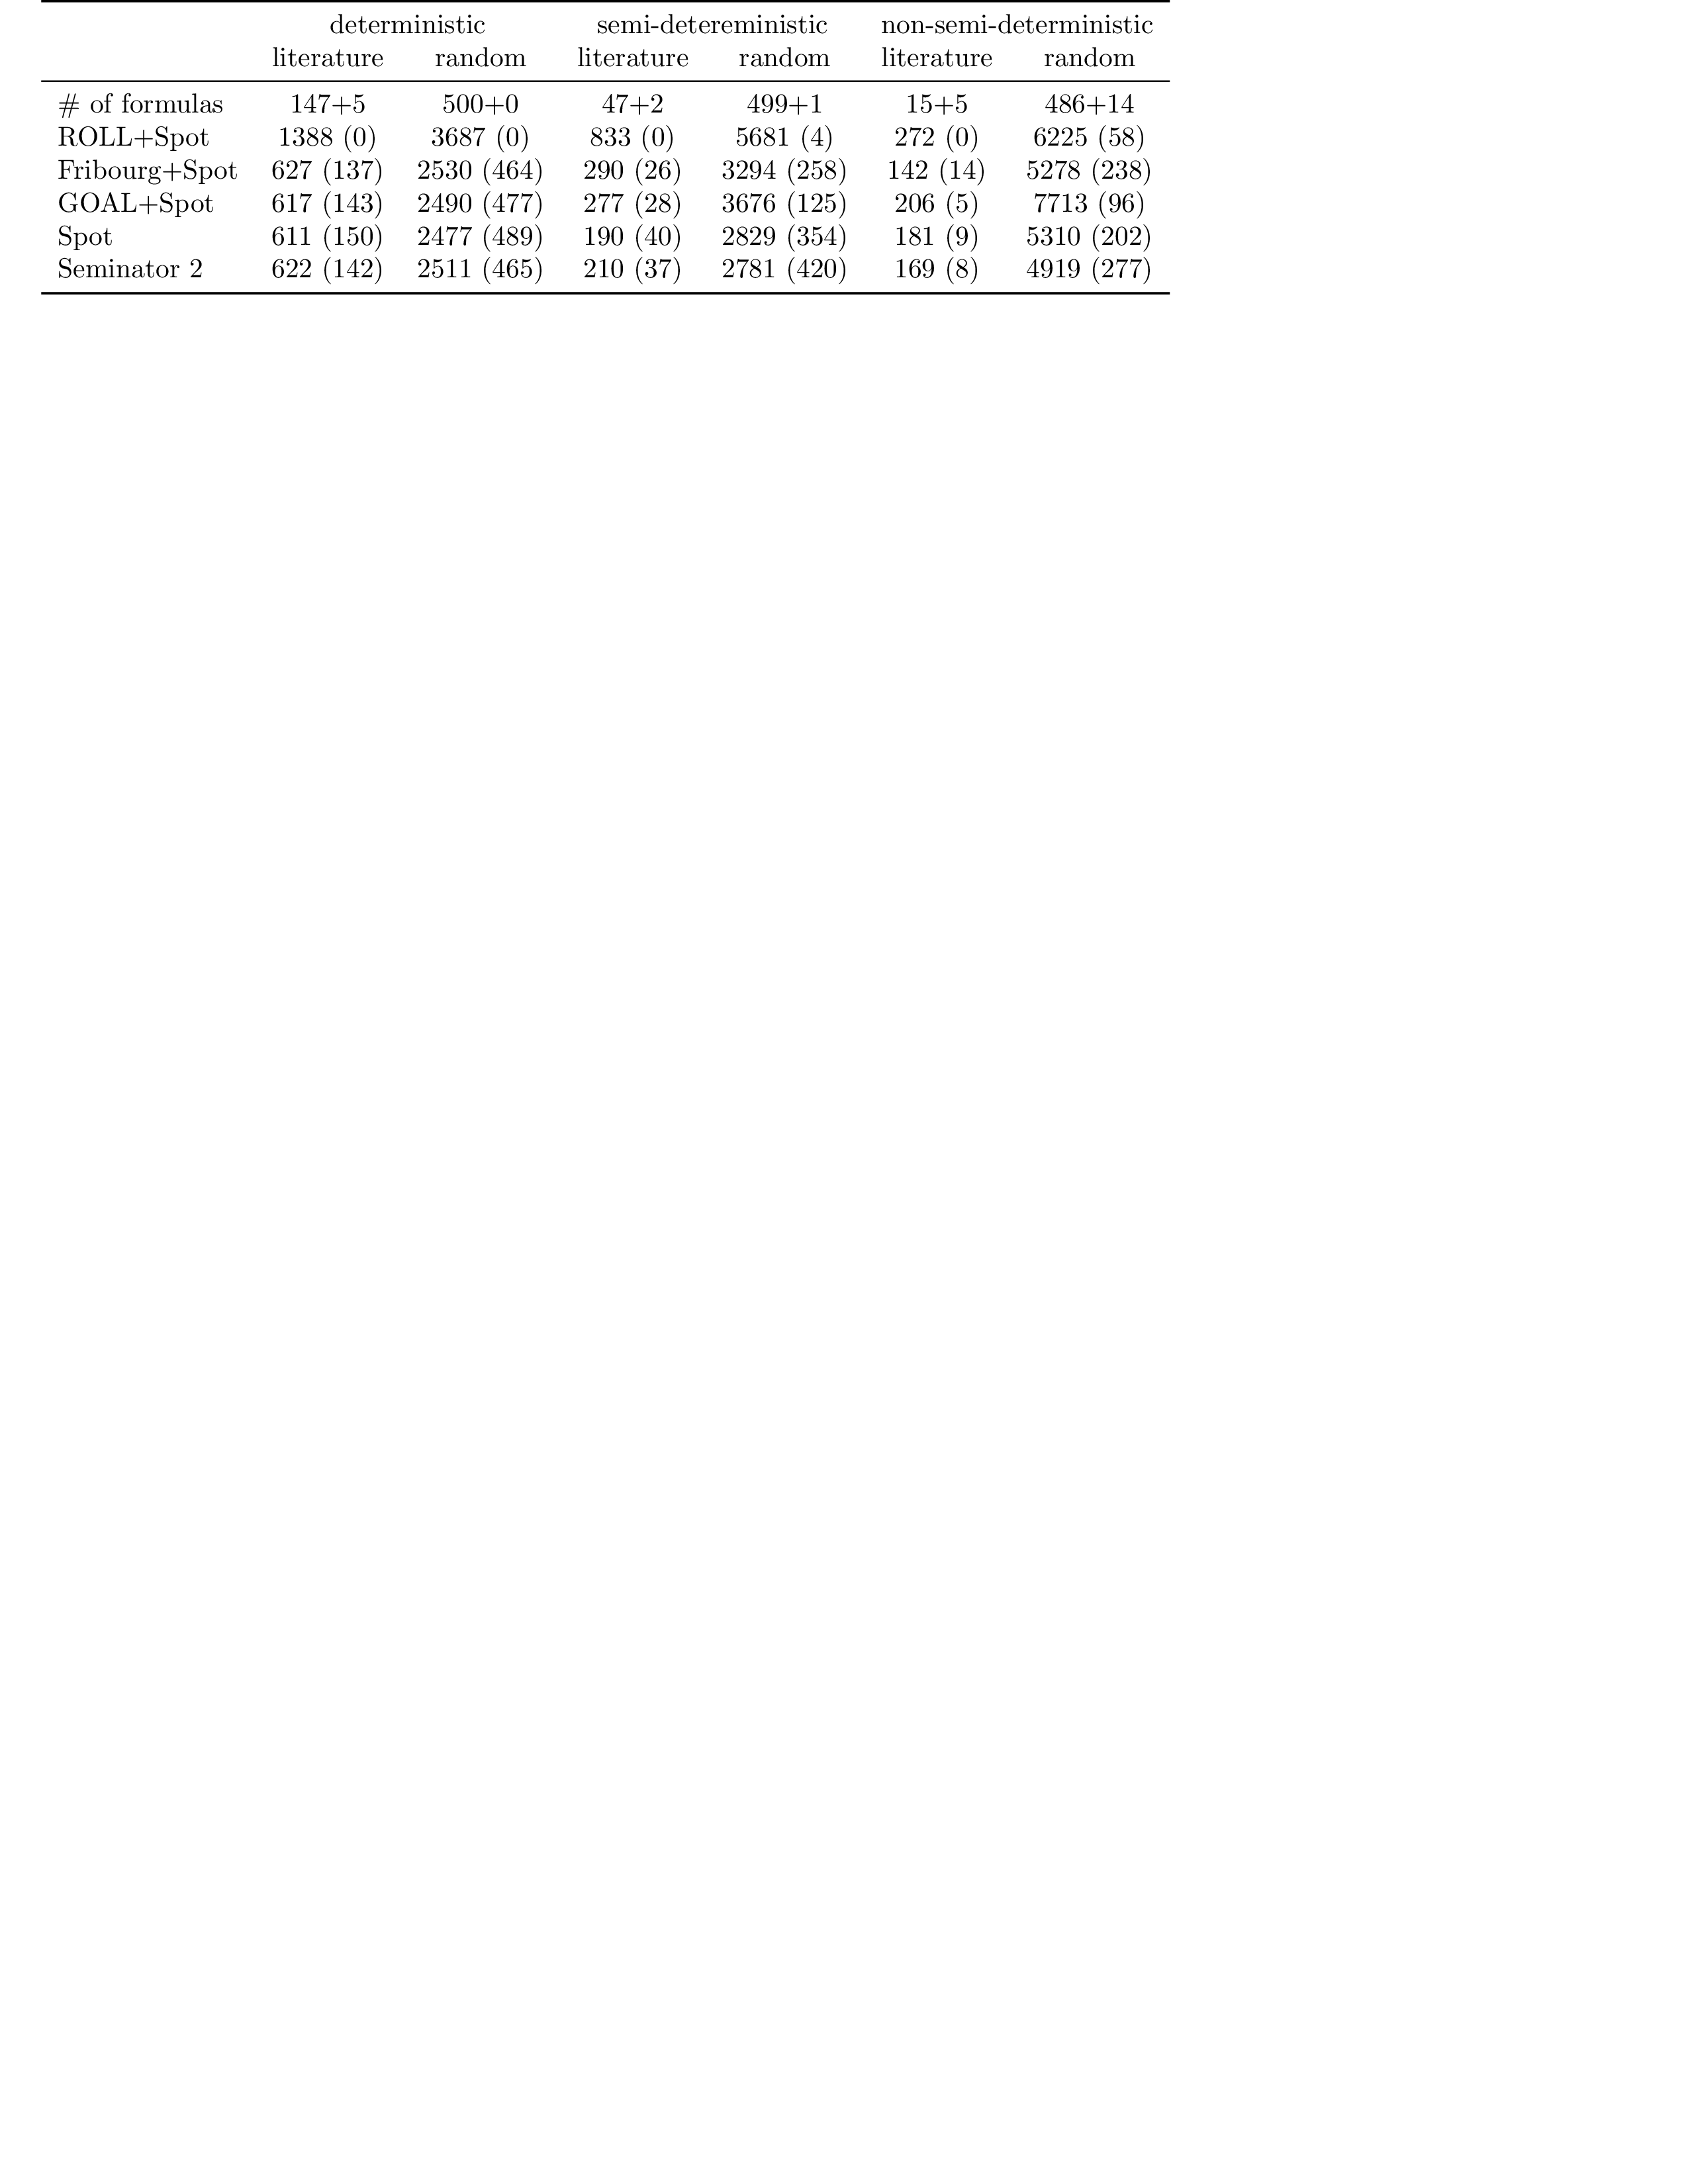

In [20]:
display_table(latex)